# MODFLOW-USG: Henry Problem

Classic saltwater intrusion problem. MODFLOW-USG-Transport replica of [MODFLOW6/Flopy](https://modflow6-examples.readthedocs.io/en/latest/_examples/ex-gwt-henry.html)
MF6 Notebook version available [here](https://modflow6-examples.readthedocs.io/en/latest/_notebooks/ex-gwt-henry.html).

In this example results from MODFLOW-USG will be evaluated.

In [54]:
import sys,os
from pathlib import Path
from tempfile import TemporaryDirectory
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import flopyu.modflow.mfbct as mfbct
import flopyu.modflow.mfddf as mfddf
import flopy

print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.9.12 (tags/v3.9.12:b28265d, Mar 23 2022, 23:52:46) [MSC v.1929 64 bit (AMD64)]
numpy version: 1.24.2
matplotlib version: 3.8.4
flopy version: 3.6.0


In [55]:
# Set temporary workspace and MODFLOW executable
# (assume executable is in users' path variable)
mfexe = "USGs_2.2.2"
modelname = "henryusgu2"
temp_dir = './' #TemporaryDirectory()
workspace = Path(temp_dir) / modelname #Path(temp_dir.name) / modelname
#shutil.mkdir(workspace, exist_ok=True)
workspace.mkdir(parents=True, exist_ok=True)
print(workspace)

temp\henryusgu2


## Model parameters

In [56]:
# Input variables for the Henry Problem
Lx = 2.0
Lz = 1.0
nlay = 40
nrow = 1
ncol = 80
delr = Lx / ncol
delc = 1.0
delv = Lz / nlay
henry_top = 1.0
henry_botm = np.asarray([np.linspace(henry_top - delv, 0.0, nlay) for j in range(ncol)]).T
print(henry_botm.shape)
print(henry_botm[:200])

qinflow = 5.702  # m3/day
dmcoef = 0.57024  # m2/day  Could also try 1.62925 as another case of the Henry problem
hk = 864.0  # m/day

nper=2
nstp=[1,500]
perlen=[1.0,0.5]
tsmult = [1.0,1.0]

steady=[True,False]

# save cell fluxes to unit 53
ipakcb = 53

# ZAIDEL STUFF
# cell centroid locations
x = np.arange(0.0, float(ncol) * delr, delr) + delr / 2.0

# ibound
ibound = np.ones((nlay, nrow * ncol), dtype=int).flatten()
#ibound[:, :, -1] = -1

#CHDs (so we can make a mfusg PCB)
#chds = [[(k * ncol) + ncol-1,0.0,0.0,35.0] for k in range(nlay)]

(40, 80)
[[0.975 0.975 0.975 ... 0.975 0.975 0.975]
 [0.95  0.95  0.95  ... 0.95  0.95  0.95 ]
 [0.925 0.925 0.925 ... 0.925 0.925 0.925]
 ...
 [0.05  0.05  0.05  ... 0.05  0.05  0.05 ]
 [0.025 0.025 0.025 ... 0.025 0.025 0.025]
 [0.    0.    0.    ... 0.    0.    0.   ]]


## Create and run the MODFLOW-USG model

In [57]:
# make the flopy model
mf = flopy.mfusg.MfUsg(modelname=modelname, exe_name=mfexe, model_ws=workspace)

#print(f'ja layer {0}')
ja = [[0, 1, ncol]] #k0c0 connections. Self, right, below
cl12 = [[0.0, 0.5*delr, 0.5*delv]]
fahl = [[0.0, delv*delc, delr*delc]]
ja += [[c] + [c-1,c+1,ncol+c] for c in range(1,ncol-1)] # layer0-->ncol-1 connections. Self, left, right, below
cl12 += [[0.0, 0.5*delr, 0.5*delr, 0.5*delv] for c in range(1,ncol-1)]
fahl += [[0.0, delv*delc, delv*delc, delr*delc] for c in range(1,ncol-1)]
ja += [[c-1] + [c-2,ncol+c-1] for c in range(ncol,ncol+1)] # layer0/ncol-1 connections. Self, left, below
cl12 += [[0.0, 0.5*delr, 0.5*delv] for c in range(ncol,ncol+1)]
fahl += [[0.0, delv*delc, delr*delc] for c in range(ncol,ncol+1)]
for k in range(1,nlay-1):
    #print(f'ja layer {k}')
    ja += [[(ncol*k), (ncol*k) + 1, (ncol * (k-1)), (ncol * (k+1))]] #layk,c1 connections. Self, right, above, below
    cl12 += [[0.0, 0.5*delr, 0.5*delv, 0.5*delv]]
    fahl += [[0.0, delv*delc, delr*delc, delr*delc]]
    ja += [[(ncol*k) + c] + [(ncol*k) + c-1, (ncol*k) + c+1, (ncol*(k-1)) + c, (ncol*(k+1)) + c] for c in range(1,ncol-1)] # layer0-->ncol-1 connections. Self, left, right, above, below
    cl12 += [[0.0, 0.5*delr, 0.5*delr, 0.5*delv, 0.5*delv] for c in range(1,ncol-1)]
    fahl += [[0.0, delv*delc, delv*delc, delr*delc, delr*delc] for c in range(1,ncol-1)]
    ja += [[(ncol*k) + c-1] + [(ncol*k) + c-2, (ncol*(k-1)) + c-1, (ncol*(k+1)) + c-1] for c in range(ncol,ncol+1)] # layerk/ncol-1 connections. Self, left, above, below
    cl12 += [[0.0, 0.5*delr, 0.5*delv, 0.5*delv] for c in range(ncol,ncol+1)]
    fahl += [[0.0, delv*delc, delr*delc, delr*delc] for c in range(ncol,ncol+1)]
for k in range(nlay-1,nlay):
    #print(f'ja layer {k}')
    ja += [[(ncol*k), (ncol*k) + 1, (ncol * (k-1))]] #layk,c1 connections. Self, right, above
    cl12 += [[0.0, 0.5*delr, 0.5*delv]]
    fahl += [[0.0, delv*delc, delr*delc]]
    ja += [[(ncol*k) + c] + [(ncol*k) + c-1, (ncol*k) + c+1, (ncol*(k-1)) + c] for c in range(1,ncol-1)] # layer0-->ncol-1 connections. Self, left, right, above
    cl12 += [[0.0, 0.5*delr, 0.5*delr, 0.5*delv] for c in range(1,ncol-1)]
    fahl += [[0.0, delv*delc, delv*delc, delr*delc] for c in range(1,ncol-1)]
    ja += [[(ncol*k) + c-1] + [(ncol*k) + c-2, (ncol*(k-1)) + c-1] for c in range(ncol,ncol+1)] # layerk/ncol-1 connections. Self, left, above
    cl12 += [[0.0, 0.5*delr, 0.5*delv] for c in range(ncol,ncol+1)]
    fahl += [[0.0, delv*delc, delr*delc] for c in range(ncol,ncol+1)]

#print(ja[:101])
#print(ja[101:201])
#print(ja[-101:])

nodelay = [ncol] * nlay
iac = np.array([len(j) for j in ja])
#print(iac[:10])
njag = sum(iac)
ja = np.asarray(sum(ja,[]), dtype=int) # flattened ja
print(ja.shape)
cl12 = np.asarray(sum(cl12,[]), dtype=float) # flattened cl12
print(cl12.shape)
fahl = np.asarray(sum(fahl,[]), dtype=float) # flattened fahl
print(fahl.shape)
area = (Lx / ncol) * delc #delc being 1...

#length_units = 3 #"centimeters"
#time_units = 1 #"seconds"

dis = flopy.mfusg.MfUsgDisU(
    mf,
    nodes=sum(nodelay),
    nodelay=nodelay,
    nlay=nlay,
    njag=njag,
    ja=ja,
    iac=iac,
    top=henry_botm.flatten() + delv,
    bot=henry_botm.flatten(),
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    tsmult=tsmult,
    steady=steady,
    laycbd=0,
    area=area,
    cl12=cl12,
    fahl=fahl,    
) 
#    itmuni=time_units,
#   lenuni=length_units,

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=1.0)
lpf = flopy.mfusg.MfUsgLpf(mf, hk=hk, vka=hk, ipakcb=ipakcb, laytyp=0, ss=1.e-32)
oc = flopy.modflow.ModflowOc(
    mf,
    stress_period_data={
        (per, nstp[per] - 1): ["print budget", "print head", "save head", "save budget", "save conc"]
    for per in range(nper)},
    compact=True,
)
sms = flopy.mfusg.MfUsgSms(
    mf,
    nonlinmeth=2,
    linmeth=2,
    numtrack=200,
    btol=2.1,
    breduc=0.10,
    reslim=1.0,
    theta=0.7,
    akappa=0.07,
    gamma=0.3,
    amomentum=0.1,
    iacl=2,
    norder=0,
    level=5,
    north=7,
    iredsys=0,
    rrctol=0.0,
    idroptol=1,
    epsrn=1.0e-5,
    mxiter=500,
    hclose=1.0e-5,
    hiclose=1.0e-6,
    iter1=50,
)
#sms = flopy.mfusg.MfUsgSms(mf)

# Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {per: [] for per in range(nper)}
#ssm_data = {}
#wel_sp1 = []
#ssm_sp1 = []
dtype = flopy.modflow.ModflowWel.get_empty(ncells=0,aux_names=['C01'], structured=False).dtype
#Initial SS flow field and init uniform TDS conditions
for k in range(nlay):
    wel_data[0].append([0 + (k*ncol), qinflow / nlay, 35.0]) # kper0 SS inflow @35mg/L TDS
# Transport TR henry problem
for k in range(nlay):
    wel_data[1].append([0 + (k*ncol), qinflow / nlay, 0.0]) # kper1 TR inflow @0mg/L TDS
    #ssm_sp1.append([k, 0, 0, 0.0, itype["WEL"]])
    #ssm_sp1.append([k, 0, ncol - 1, 35.0, itype["BAS6"]])
#wel_data[0] = wel_sp1
#ssm_data[0] = ssm_sp1
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_data, ipakcb=ipakcb, dtype=dtype, options=["AUX C01"])

#CHD package
#chd = flopy.modflow.ModflowChd(mf, stress_period_data={0:chds}, ipakcb=ipakcb)


(15760,)
(15760,)
(15760,)


### make mfusg BCT/ DDF packages

In [58]:
# Create the basic MT3DMS model structure
# mt = flopy.mt3d.Mt3dms(modelname, 'nam_mt3dms', mf, model_ws=workspace)
"""btn = flopy.mt3d.Mt3dBtn(
    swt,
    nprs=-5,
    prsity=0.35,
    sconc=35.0,
    ifmtcn=0,
    chkmas=False,
    nprobs=10,
    nprmas=10,
    dt0=0.001,
)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=0.0, trpt=1.0, trpv=1.0, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)

# Create the SEAWAT model structure
# mswt = flopy.seawat.Seawat(modelname, 'nam_swt', mf, mt, model_ws=workspace, exe_name='swtv4')
vdf = flopy.seawat.SeawatVdf(
    swt,
    iwtable=0,
    densemin=0,
    densemax=0,
    denseref=1000.0,
    denseslp=0.7143,
    firstdt=1e-3,
)
"""

bct = mfbct.ModflowBct(mf, porosity=0.35, idisp=1, ixdisp=0, sconc=35.0, diffnc=dmcoef, ict=0, itvd=0, ibctcb=0) #flopy.modflow.ModflowBct(mf, porosity=0.35, idisp=1, ixdisp=0, sconc=35.0, diffnc=dmcoef, ict=0, itvd=0, ibctcb=54)
ddf = mfddf.ModflowDdf(
    mf, rhofresh=1000.0, rhostd=1025.0, cstd=35.0,
    ithickav=0, imph=0,isharp=0,
)
#lrcd = {0:[[k, 0, ncol-1, 0, 35.0] for k in range(mf.dis.nlay)]}   #this pcb will be applied to all stress periods
#pcb = flopy.modflow.ModflowPcb(mf, stress_period_data=lrcd)
"""lrcd = {0:[[(layer*ncol)+ncol-1, 1.0, 1.0, 35.0] for layer in range(nlay)]}   #this chdwill be applied to all stress periods
dtype = flopy.modflow.ModflowChd.get_empty(ncells=0,aux_names=['C01'], structured=False).dtype
print(dtype)
chd = flopy.modflow.ModflowChd(mf, stress_period_data=lrcd, aux_names=['C01'], dtype=dtype, options=["AUX C01"])"""
ghbcond = hk * delv * delc / (0.5 * delr)
lrcd = {0:[[(layer*ncol)+ncol-1, 1.0, ghbcond, 35.0] for layer in range(nlay)]}   #this chdwill be applied to all stress periods
dtype = flopy.modflow.ModflowGhb.get_empty(ncells=0,aux_names=['C01'], structured=False).dtype
print(dtype)
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=lrcd, dtype=dtype, options=["AUX C01"])

(numpy.record, [('node', '<i4'), ('bhead', '<f4'), ('cond', '<f4'), ('C01', '<f4')])


### Write and run the model

In [59]:

mf.write_input()

# edit the OC file to add conc file unit
with open(workspace / f"{modelname}.oc",'r') as foo:
    lines = foo.readlines()
with open(workspace / f"{modelname}.oc",'w') as foo:
    lines.insert(1,'CONCENTRATION SAVE UNIT 52\n')
    foo.writelines(lines)

# edit the NAM file to add conc file unit
with open(workspace / f"{modelname}.nam",'r') as foo:
    lines = foo.readlines()
with open(workspace / f"{modelname}.nam",'w') as foo:
    lines.append("DATA(BINARY)      52  henryusgu2.con REPLACE")
    foo.writelines(lines)

# remove any existing head files
try:
    (workspace / f"{modelname}.hds").unlink(missing_ok=True)
except:
    pass

# run the model
success, buff = mf.run_model(silent=True, report=True)
assert success, "Failed to run"
for line in buff:
    print(line)


                                  USG-TRANSPORT 
    MODFLOW-USG GROUNDWATER FLOW AND TRANSPORT MODEL
                             Version USG-TRANSPORT VERSION 2.02.1            

 Using NAME file: henryusgu2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/05/13 15:26:17

 Solving:  Stress period:     1    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     1    Groundwater Transport Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater Transport Eqn.
 Solving:  Stress period:     2    Time step:     2    Groundwater Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Groundwater Transport Eqn.
 Solving:  Stress period:     2    Time step:     3    Groundwater Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Groundwater Transport Eqn.
 Solving:  Stress period:     2    Time step:     4    Groundwater Flow Eqn.
 S

### Plot MODFLOW-USG results

In [60]:
import numpy as np
import flopy.utils.binaryfile as bf
# Extract the heads
fname = os.path.join(workspace, "henryusgu2.hds")
headobj = bf.HeadUFile(fname)
times = headobj.get_times()
kstpkper = headobj.get_kstpkper()
print(times)
head = headobj.get_data(kstpkper=kstpkper[-1]) #totim=times[-1])
print(np.asarray(head).shape)

[1.0, 1.5]
(40, 80)


In [61]:
# Load data
#ucnobj = bf.UcnFile(os.path.join(workspace, "MT3D001.UCN"), model=swt)
ucnobj = bf.HeadUFile(os.path.join(workspace, "henryusgu2.con"), text="CONC")
kstpkper = headobj.get_kstpkper()
print(kstpkper)
#times = ucnobj.get_times()
#print(times)

concentration = ucnobj.get_data(kstpkper=kstpkper[-1])
print(workspace)

#ucnobj_sorab = bf.HeadUFile(r"D:\Software\MFUSG\Beta versions\USG-Transport_Version-2.3.0\Example Datasets\Documented_Example_5-Henry\Yo1.con", text="CONC")
#conc_sorab = ucnobj_sorab.get_data(totim=times[-1])

"""
cbbobj = bf.CellBudgetFile(os.path.join(workspace, "henryusgu2.cbc"))
times = cbbobj.get_times()
qx = cbbobj.get_data(text="flow right face", totim=times[-1])[0]
qz = cbbobj.get_data(text="flow lower face", totim=times[-1])[0]

# Average flows to cell centers
qx_avg = np.empty(qx.shape, dtype=qx.dtype)
qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0 : ncol - 1] + qx[:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
qz_avg = np.empty(qz.shape, dtype=qz.dtype)
qz_avg[1:, :, :] = 0.5 * (qz[0 : nlay - 1, :, :] + qz[1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * qz[0, :, :]"""

[(0, 0), (499, 1)]
temp\henryusgu2


'\ncbbobj = bf.CellBudgetFile(os.path.join(workspace, "henryusgu2.cbc"))\ntimes = cbbobj.get_times()\nqx = cbbobj.get_data(text="flow right face", totim=times[-1])[0]\nqz = cbbobj.get_data(text="flow lower face", totim=times[-1])[0]\n\n# Average flows to cell centers\nqx_avg = np.empty(qx.shape, dtype=qx.dtype)\nqx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0 : ncol - 1] + qx[:, :, 1:ncol])\nqx_avg[:, :, 0] = 0.5 * qx[:, :, 0]\nqz_avg = np.empty(qz.shape, dtype=qz.dtype)\nqz_avg[1:, :, :] = 0.5 * (qz[0 : nlay - 1, :, :] + qz[1:nlay, :, :])\nqz_avg[0, :, :] = 0.5 * qz[0, :, :]'

(40, 80)


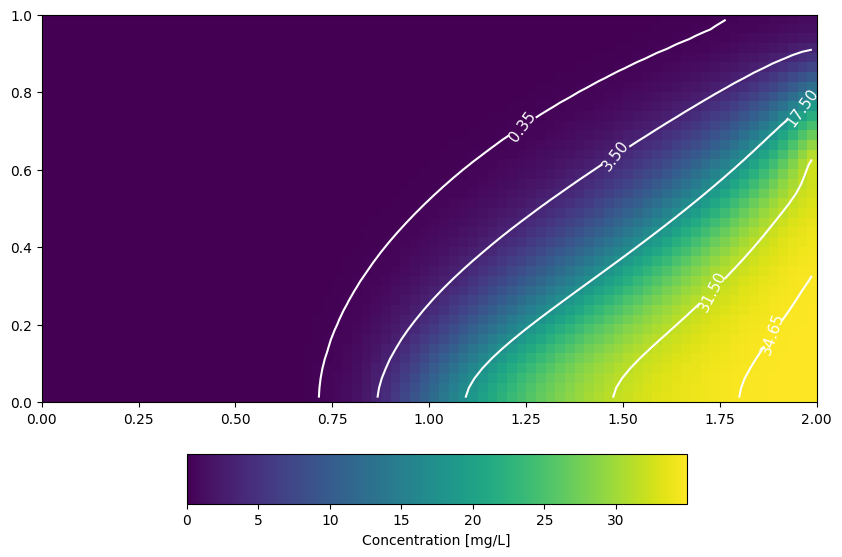

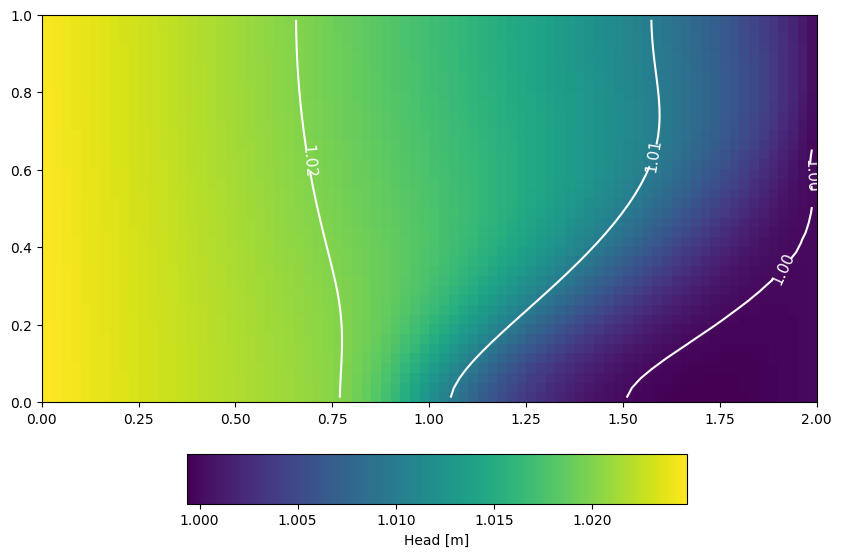

Text(0.5, 1.0, 'Simulated Heads')

In [62]:
# Make the conc plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
conc_im = ax.imshow(
    concentration, interpolation="nearest", extent=(0, Lx, 0, Lz)
)
#ax2 = fig.add_subplot(2, 1, 2, aspect="equal")
#conc_sorab_im = ax2.imshow(
#    conc_sorab, interpolation="nearest", extent=(0, Lx, 0, Lz)
#)

dis2 = flopy.modflow.ModflowDis(
    flopy.modflow.Modflow(),
    nlay,
    nrow,
    ncol,
    delr=delr,
    delc=delc,
    top=henry_top,
    botm=henry_botm,
    perlen=perlen,
    nstp=nstp,
    nper=2,
    steady=False,
    laycbd=0,
    rotation=None,
)
y, x, z = dis2.get_node_coordinates()
X, Z = np.meshgrid(x, z[:, 0, 0])
iskip = 3
"""
ax.quiver(
    X[::iskip, ::iskip],
    Z[::iskip, ::iskip],
    qx_avg[::iskip, 0, ::iskip],
    -qz_avg[::iskip, 0, ::iskip],
    color="w",
    scale=5,
    headwidth=3,
    headlength=2,
    headaxislength=2,
    width=0.0025,
){"""
cax = fig.add_axes([0.27, 0.2, 0.5, 0.05])
fig.colorbar(conc_im, cax=cax, orientation='horizontal', label="Concentration [mg/L]")

print(np.asarray(concentration).shape)
levels = [0] + [35 * f for f in [0.01, 0.1, 0.5, 0.9, 0.99]]
contour_set = ax.contour(X,Z, np.asarray(concentration), levels=levels, colors="white")
plt.clabel(contour_set, fmt="%.2f", colors="white", fontsize=11)

plt.savefig(os.path.join(workspace, "henryusgu2.png"))
plt.show()

# Make a simple head plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
im = ax.imshow(head, interpolation="nearest", extent=(0, Lx, 0, Lz))
cax = fig.add_axes([0.27, 0.2, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal', label="Head [m]")

levels = [1+(v*0.01) for v in range(-1,100)]
contour_set = ax.contour(X,Z, np.asarray(head), levels=levels, colors="white")
plt.clabel(contour_set, fmt="%.2f", colors="white", fontsize=11)

y, x, z = dis2.get_node_coordinates()
X, Z = np.meshgrid(x, z[:, 0, 0])
iskip = 3
"""
ax.quiver(
    X[::iskip, ::iskip],
    Z[::iskip, ::iskip],
    qx_avg[::iskip, 0, ::iskip],
    -qz_avg[::iskip, 0, ::iskip],
    color="w",
    scale=5,
    headwidth=3,
    headlength=2,
    headaxislength=2,
    width=0.0025,
)
"""


plt.show()
ax.set_title("Simulated Heads")

In [63]:
"""try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass"""

'try:\n    # ignore PermissionError on Windows\n    temp_dir.cleanup()\nexcept:\n    pass'